<a href="https://colab.research.google.com/github/RosaMeyer/2023-lectures/blob/main/Week6_Linear_Model_Rep_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Logistic Classifier with DistilBERT-Based Feature Representation - Evaluation on new data

The model will be used as one multilingual logistic regression model for evaluating our questions.

## Data preprocessing

In [7]:
import pandas as pd
import numpy as np
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
import torch

from tqdm import tqdm # used for feature representations for DistilBert

## Get new questions

In [8]:
with open("test.json", "r", encoding="utf-8") as file:
    new_data = json.load(file)

new_data = pd.DataFrame(new_data)

## Helper function for DistilBERT embeddings

In [9]:
def get_distilbert_representations(questions, contexts, model_name="distilbert-base-uncased", max_length=256):
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name)
    model.eval()

    all_embeddings = []

    for q, c in tqdm(zip(questions, contexts), total=len(questions), desc="Encoding"):
        combined = f"question: {q} context: {c}"
        inputs = tokenizer(
            combined,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_length
        )
        with torch.no_grad():
            outputs = model(**inputs)
        # Use [CLS] token (first hidden state) as representation
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        all_embeddings.append(cls_embedding)

    return np.array(all_embeddings)

## Evaluate on our new questions



In [10]:
# Evaluate trained model with plotting
def evaluate_model(model, scaler, features, labels, language_name):
    print(f"\nEvaluating model for {language_name}...")

    scaled_features = scaler.transform(features)

    predictions = model.predict(scaled_features)
    probabilities = model.predict_proba(scaled_features)

    accuracy = accuracy_score(labels, predictions)

    print(f"\nValidation accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=["Not Answerable", "Answerable"]))

    cm = confusion_matrix(labels, predictions)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Answerable", "Answerable"],
                yticklabels=["Not Answerable", "Answerable"])
    plt.title(f"Confusion Matrix - {language_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return {
        "accuracy": accuracy,
        "predictions": predictions,
        "probabilities": probabilities,
        "confusion_matrix": cm
    }

In [11]:
def evaluate_on_new_questions(test_json_path):
    print(f"\nLoading new questions from {test_json_path} ...")
    test_df = pd.read_json(test_json_path)

    if not {"question", "context"}.issubset(test_df.columns):
        raise ValueError("test.json must contain 'question' and 'context' columns.")

    model = joblib.load("linear_model_multilingual.pkl")
    scaler = joblib.load("scaler_multilingual.pkl")

    X_test = get_distilbert_representations(test_df["question"], test_df["context"])
    X_test_scaled = scaler.transform(X_test)

    if "answerable" in test_df.columns:
        metrics = evaluate_model(model, scaler, X_test, test_df["answerable"], language_name="Multilingual Test")
        return metrics
    else:
        y_pred = model.predict(X_test_scaled)
        test_df["predicted_answerable"] = y_pred
        print("\nPredictions (no gold labels provided):")
        print(test_df[["question", "predicted_answerable"]].head())
        return test_df


Loading new questions from test.json ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Encoding: 100%|██████████| 39/39 [00:34<00:00,  1.13it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Evaluating model for Multilingual Test...

Validation accuracy: 0.7436

Classification Report:
                precision    recall  f1-score   support

Not Answerable       0.00      0.00      0.00        10
    Answerable       0.74      1.00      0.85        29

      accuracy                           0.74        39
     macro avg       0.37      0.50      0.43        39
  weighted avg       0.55      0.74      0.63        39



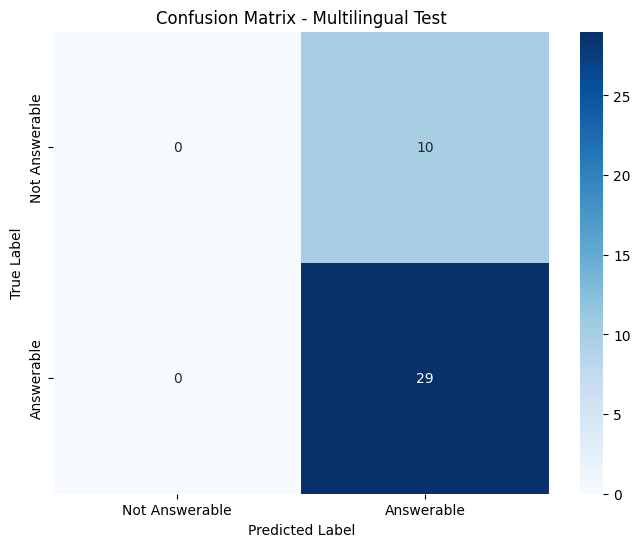

In [12]:
test_results = evaluate_on_new_questions("test.json")